# CSCE 623 Homework Assignment 5
## Student Name:
## Date:
(Solution adapted from HW5 submission, Capt Justin Merrick, CSCE 623, 2019)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# yellowbrick details:    https://www.scikit-yb.org/en/latest/quickstart.html
from yellowbrick.features import Rank2D
from yellowbrick.target import FeatureCorrelation
from yellowbrick.regressor import ResidualsPlot
#from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import FeatureImportances

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline

C:\Users\brett\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load and Preprocess the data

## STEP 0. 
(instructor provided) Load the ILSR_hitters.csv dataset.  Remove the observations for whom the salary information is unknown, and then 

In [2]:
# STEP 0  - Load data & convert categorical features - instructor provided code

state = 1  #random seed
Hitters = pd.read_csv('ISLR_Hitters.csv',index_col=0)
Hitters = Hitters.dropna(how='any')
Hitters = Hitters.reset_index()

Hitters = Hitters.drop(['index'],axis=1)
Hitters['League'] = Hitters['League'].map({'A': 0, 'N': 1})
Hitters['Division'] = Hitters['Division'].map({'E': 0, 'W': 1})
Hitters = Hitters.drop(['NewLeague'],axis=1)

Hitters.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0
3,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,750.0


## STEP 1.  Build functions for log transforming salaries 

Student Code Required

Log-transform the salaries (salaries listed are in $1000’s).  Note that you will need to account for this log-transformation when presenting your results (transform your precisions, loss, MSE, improvement, etc. back to real salary dollars when possible)

In [3]:
#STEP1 

# helper functions for transformation
# the transformed salary should work better for model fitting
def salary_transform(salary):
    transformed_salary = np.log10(salary)  #PLACEHOLDER ONLY ---> STUDENT COMPLETE THIS CODE TO TRANSFORM SALARY
    return transformed_salary

# the untransformed salary is needed for test set performance reporting and residuals analysis
def salary_untransform(transformed_salary):
    salary = 10**transformed_salary  #PLACEHOLDER ONLY ---> STUDENT COMPLETE THIS CODE TO UNTRANSFORM SALARY
    return salary

#transform the salary
Hitters['Salary'] = salary_transform(Hitters.Salary)

# note that this block will give an error until the salary component is filled out

# STEP 2.
(Code Provided) Using sklearn.model_selection.train_test_split with random_state = 1,  create a “non-test” set consisting of 200 observations and a test set consisting of the remaining observations.  Sequester the test set until  the performance reporting steps (9-11).

In [4]:
Hitters_nonTest, Hitters_test = train_test_split(Hitters, train_size = 200, random_state=1)
Hitters_nonTest.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary
228,528,122,1,67,45,51,4,1716,403,12,211,146,155,0,1,209,372,17,2.544068
29,379,106,10,38,60,30,14,6207,1906,146,859,803,571,1,1,72,170,24,2.929419
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,2.676694
177,381,110,9,61,45,32,7,3015,834,40,451,249,168,1,0,228,7,5,2.903090
122,309,94,5,37,32,26,13,4618,1330,57,616,522,436,1,0,161,3,3,2.778151


# Explore the data & make hypotheses

## STEP 3.
Explore the data.  Use plots and discuss relationships between available features and Salary.  Consider using the seaborn package to facilitate your exploration – for example, make a heatmap plot of the correlation between each pair of features to help you decide which pairs of features to explore further with pairs plots or scatterplots.  Make at least one hypothesis about which features will be useful in predicting salary.  

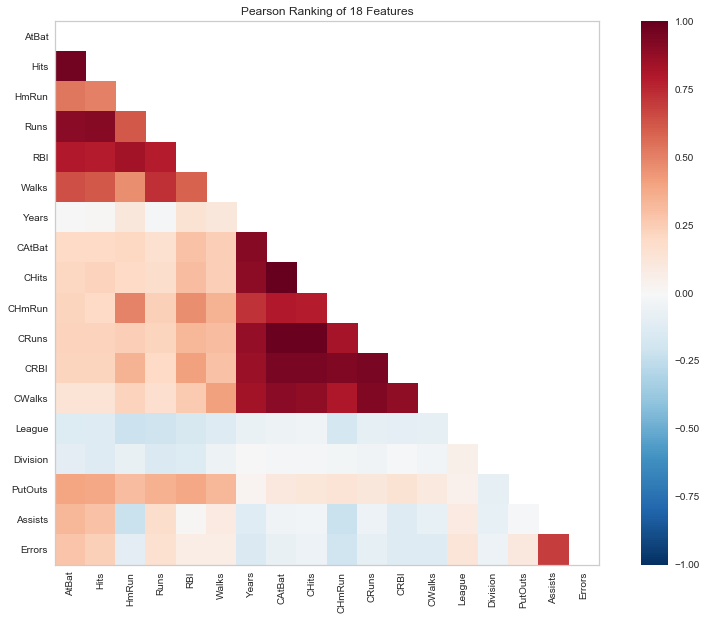

C:\Users\brett\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


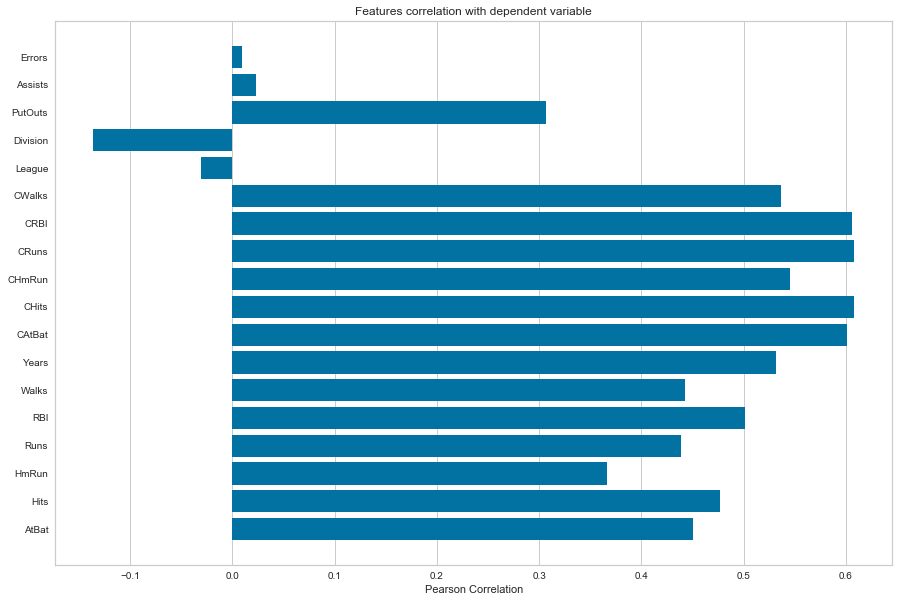

In [5]:
features = Hitters_nonTest.drop('Salary', axis=1)
targets = Hitters_nonTest['Salary']
corr_viz = Rank2D(features=features.columns.values, algorithm='pearson', size=(1080,720))
corr_viz.fit(features, targets)
corr_viz.transform(features)
corr_viz.poof()

tar_corr = FeatureCorrelation(labels=features.columns.values, size=(1080,720))
tar_corr.fit(features, targets)
tar_corr.poof()

As when working with this dataset in HW4, there are two main blocks of features that are highly correlated with one another, an in-season stats and a career stats block. By using this knowledge and the correlation plot with the dependent variable shown above, it becomes clear that at least one of the features CRBI, CRuns, CHits, and CAtBat will likely be used in any model that hopes to have a degree of success. It also becomes clear why PutOuts was seen in models with more features, as it has a moderate correlation with Salary while also having a low to moderate correlation with the other features. The reason for Division being in most of the models in HW4 is also more clear, as it is the feature with the strongest negative correlation with Salary and thus it likely can account for variance that cannot be accounted for with other features.

# Train the model & Tune Hyperparameters using Cross-Validation

## STEP 4.
Using sklearn k-fold split (sklearn.model_selection.KFold), write code to set up a k-fold cross-validation with the goal of choosing the best hyperparameters for a random forest model (sklearn.ensemble.RandomForestRegressor)     Select and provide rationale for your choice for n_splits based on amount of data you have available in the non-test set.  Your goal is to determine the best combination of two parameters: maximum tree depth (max_depth), and the number of features to consider at each split (max_features).   The hyperparameter  max_depth of the trees should include integer values from 1 to 20, and your exploration over max_features should include values from 1 to p (all features).  You can decide whether to fix the number of trees (n_estimators) or include it as a third hyperparameter to explore (it should start with at least 100 but you may want to explore higher values if you will tune this hyperparameter with cross-validation) – then explain whether you are selecting a specific value or tuning this value with cross validation.   Since you will use a cross-validation wrapper to tune hyperparameters, set oob_score to False in the initialization call to RandomForestRegressor.   For each tuple of (max_depth, max_features), compute and collect the mean k-fold cross-validation MSE using predict().  

In [6]:
depths = np.arange(1,20+1)
num_features = np.arange(1,len(features.columns.values))
combos = np.array(np.meshgrid(depths, num_features)).T.reshape(-1,2)
num_trees = 200
mses = []
for combo in combos:
    estimator = RFR(n_estimators=num_trees, max_depth=combo[0], max_features=combo[1], random_state=state)
    val_results = cross_validate(estimator, features, targets, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    mean_mse = np.abs(val_results['test_score']).mean()
    mses.append(mean_mse)

mses = np.array(mses)
best_mse = mses.min()
bestcombo = combos[np.argmin(mses)]

## STEP 5. 
Provide convincing visual evidence of the validation MSE performance (from step 5) as a function of max_features and max_depth (and n_estimators if you chose to tune it).    A good way to do this is to plot the error on a graph as a function of the two dimensions max_depth and max_features.  Contour maps work here.

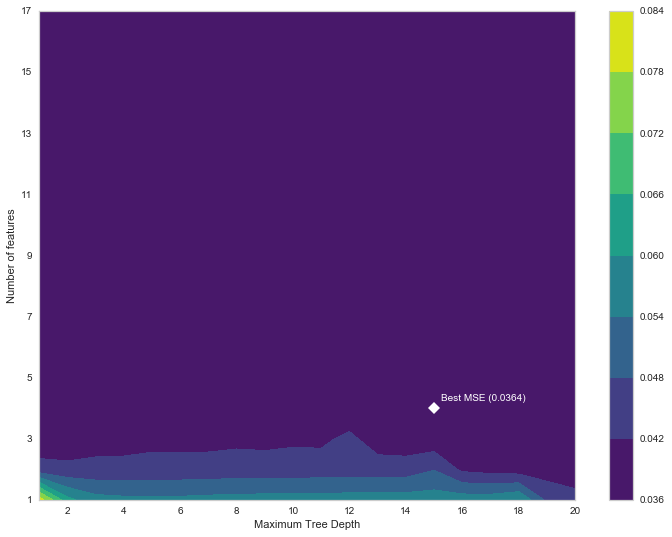

In [7]:
xx, yy = np.meshgrid(depths, num_features)
fig, ax = plt.subplots(figsize=(12,9))
cons = ax.contourf(xx, yy, mses.reshape(-1, len(depths)), cmap='viridis')

ax.plot(bestcombo[0],bestcombo[1], marker='D', markersize=8, color='w')
ax.annotate('Best MSE (%.4f)' %best_mse, bestcombo, bestcombo+0.25, color='w')
ax.set_xticks(range(2,22,2))
ax.set_yticks(range(1,18,2))
ax.set_ylabel('Number of features')
ax.set_xlabel('Maximum Tree Depth')
fig.colorbar(cons)
plt.show();

## STEP 6.
Using code, determine, display visually, and report the values of these parameters with the lowest MSE.  Discuss the minimum value of max_features in light of the random forest recommendation for max_features: sqrt(p) or p/3.  Did your result agree with the general guidance on max features?

From the contour plot above we can see that the best MSE (0.364) occurs with 4 features considered per split and a maximum tree depth of 14 splits. With 17 total features, 4 features is the closest integer to $\sqrt{17}$. Above 4 features, there is little variation in the MSE, nor is there significant variation in the MSE when examining tree depth at or above 4 features. This is as hypothesized, though the best number of splits at 14 is on the higher end, it matches with the guidance that the trees in a random forest should be grown deeply.

## STEP 7.
Using the best values of  max_features and max_depth found with MSE, fit a new RandomForestRegressor model trained on all the non-test data.

In [8]:
best_estimator = RFR(n_estimators=num_trees, max_depth=bestcombo[0], max_features=bestcombo[1], random_state=state, n_jobs=-1)
best_estimator.fit(features, targets)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

# Reporting performance on the Test Set

## STEP 8.
Using code, determine and report the quality of the model for predicting salary on the sequestered test set.  Don’t forget to handle the log transformation you did in data preprocessing – your performance values should be based on real dollars (not log-transformed dollars).  

In [9]:
test_features = Hitters_test.drop('Salary', axis=1)
test_targets = salary_untransform(Hitters_test.Salary)
yhat = best_estimator.predict(test_features)
test_predicts = salary_untransform(yhat)
test_mse = MSE(test_targets, test_predicts)
print('Test MSE:', test_mse)

Test MSE: 107712.13344424935


## STEP 9.
Develop a scatterplot of the regression residuals:  The figure’s x axis expresses the true dollar amount of salary, the figure’s y axis represents the prediction error (positive values mean underprediction, negative values mean overprediction, and y=0 would mean correct prediction).   Discuss these residuals.  Are they evenly distributed about y=0 through the range of possible true salaries?  Do you see any patterns which would suggest true salaries for which prediction would be poor?

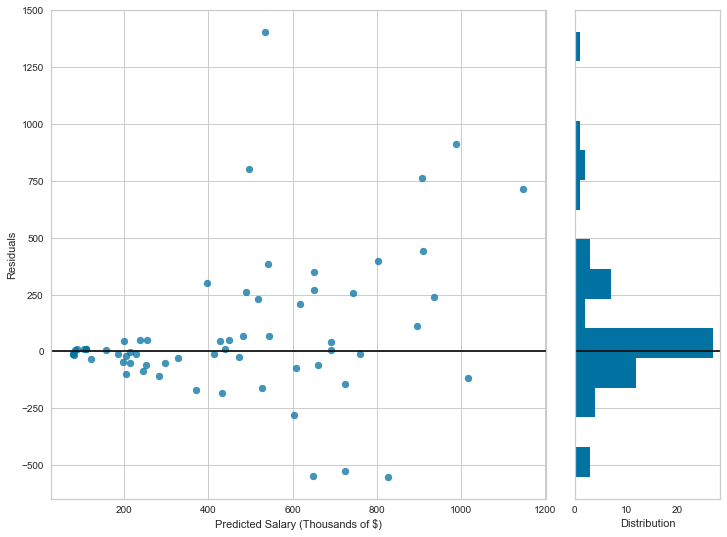

In [10]:
residuals = test_targets - test_predicts
fig = plt.figure(figsize=(12,9))
ax = plt.subplot2grid((1,4), (0,0), colspan=3)
hax = plt.subplot2grid((1,4), (0,3))
hax.set_sharey = ax
ax.scatter(test_predicts, residuals, alpha=0.75)
ax.set_ylabel('Residuals')
ax.set_xlabel('Predicted Salary (Thousands of $)')
ax.axhline(y=0, c='k')
hax.hist(residuals, bins=15, orientation='horizontal')
hax.axhline(y=0, c='k')
hax.set_xlabel('Distribution')
hax.set_yticklabels([])
hax.grid(False, axis='x')

In [11]:
print("overpredicted observation count ",(residuals < 0).sum())
print("underpredcited observation count ",(residuals > 0).sum())

overpredicted observation count  30
underpredcited observation count  33


The residuals lie predominantly in the neighborhood of zero and are evenly distributed in number about this mode. However, the positive tail of the distribution is nearly 3x longer than the negative tail, indicating that when the model underpredicts, it does so by a significant amount. This skewed tail and a large mode make it unlikely that the residuals are distributed normally. Additionally, there appears to be some heteroscedasticity to the true salary, as indicated by the increasing magnitude of the residuals as the predicted salary increases. This likely drove the log-transform originally performed on the data. Regardless, random forests are significantly negatively affected by heteroscedasticity, even with the use of transformed data for the model-fitting. This partially explains the large MSE observed.

## STEP 10.
Using the model, report on variable importance - which variables appear to be the most important predictors in the model?  Using the sklearn feature_importance_ attribute of the best fitted model, provide numerical and visual evidence to support your answer (make sure to sort your outputs by feature importance).

C:\Users\brett\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


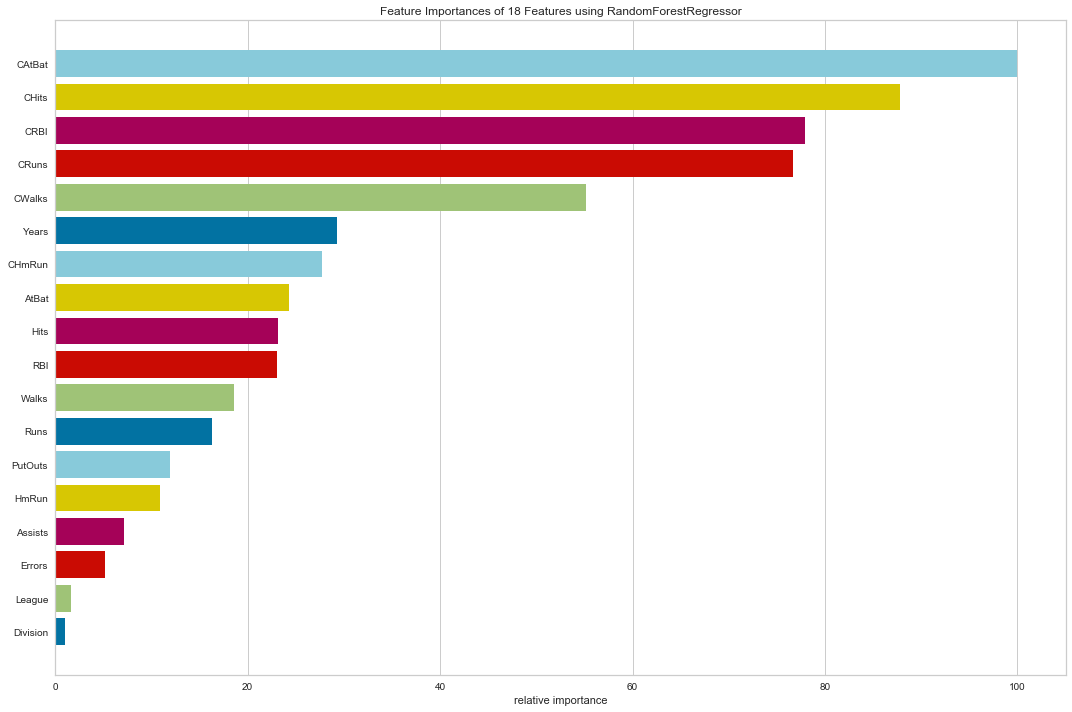

In [12]:
feat_imp = FeatureImportances(best_estimator, size=(1080,720))
feat_imp.fit(features, targets)
feat_imp.poof()

The career statistics dominate the feature importance plot above, with CAtBat being the most important feature to the model and CHmRun being the least important career statistic. Following the career statistics, the second block of correlated features, the in-season at-bat features, are present. Following this block, the fielding features continue to have decreased importance until the League and Division features round out the plot with the least importance. Due to the high correlation between the career statistics and the in-season at-bat statistics, it is possible that this plot, which utilizes the biased measure mean decrease in impurity to determine importance, is incorrect.

In [13]:
def dropcol_importances(rf, X_train, y_train, seed): 
    rf_ = clone(rf) 
    rf_.random_state = seed 
    rf_.fit(X_train, y_train) 
    baseline = MSE(y_train, rf_.predict(X_train))
    imp = [] 
    for col in X_train.columns: 
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf) 
        rf_.random_state = seed 
        rf_.fit(X, y_train)
        o = MSE(y_train, rf_.predict(X))
        imp.append(o - baseline) 
    imp = np.array(imp)
    I = pd.DataFrame( data={'Feature':X_train.columns, 'Importance':imp}) 
    I = I.set_index('Feature') 
    I = I.sort_values('Importance', ascending=True) 
    return I

In [14]:
drop_imps = dropcol_importances(best_estimator, features, targets, state)

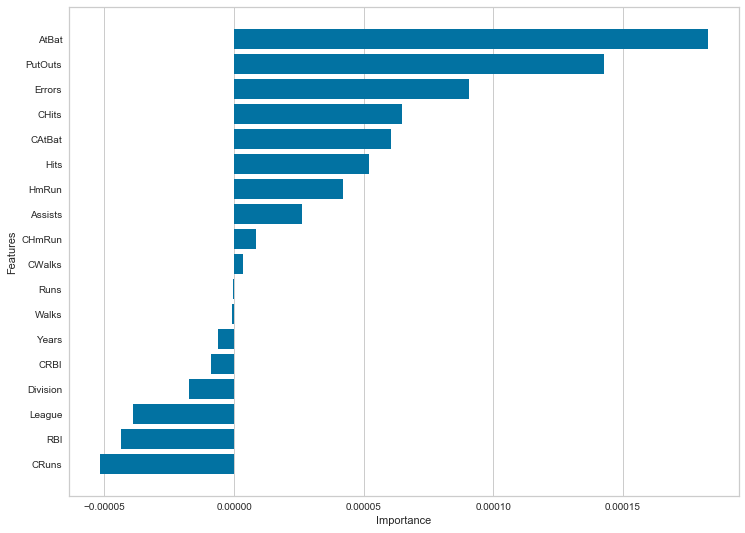

In [15]:
fig, ax = plt.subplots(figsize=(12,9))
ax.barh(np.arange(drop_imps.shape[0]),drop_imps.Importance)
ax.set_yticks(np.arange(drop_imps.shape[0]))
ax.set_yticklabels(drop_imps.index.values)
ax.set_ylabel('Features')
ax.set_xlabel('Importance')
ax.grid(False, axis='y')

By examining the change in MSE that occurs when a feature is not used in the model-fitting process, a different idea of the feature importances is revealed. This interpretation of importance takes into account the collinearity of the features. From it, we can see that AtBat is the most important feature because it caused the MSE to increase the most when it was removed from the model. At the other end, League, years, CRuns, RBI, CRBI, HmRun, and CHmRun all have negative importances, meaning that removing them from the model cause the MSE to go down, meaning they are unimportant to the model.

## References

For impact of heteroscedasticity on trees and forests:

https://arxiv.org/pdf/1606.05273.pdf

https://www.stat.sfu.ca/content/dam/sfu/stat/alumnitheses/2015/SharlaGelfandProject.pdf

For information on other feature importance calculations:
https://explained.ai/rf-importance/